Justin Dano <br>
FE550 - Data Visualization Applications<br>
Assignment #4<br>
Due 10/25/2017<br>

#  Cryptocurrencys and their Correlation with other Financial Assets

## Introduction

Before building an investment strategy on any type of cryptocurrency, it is important to understand how cryptocurrencies move with other financial assets. When comparing different financial assets it is important that the assets have somewhat similar economic characteristics. Cryptocurrencies, along with fiat currencies can be classified as 'Store of Value Assets', since their value is derived solely on what humans believe it is worth<sup>1</sup>. In this analysis, I aim to answer the following questions:


<b> 1. What is the correlation between Bitcoin and major fiat currencies? </b><br>
<b> 2. How has the correlation (or lack thereof) between Bitcoin and other fiat currencies changed over time? </b>

The correlation coefficient is calculated by taking the daily log returns of both Bitcoin and a fiat currency over a predefined look-back window. To see how the correlation trends over time, a rolling correlation will be calculated. This analysis will be broken into three parts: a visualization of the correlation between Bitcoin and the US Dollar. The next part will visualize the correlation between Bitcoin and several major fiat currencies. Finally, an attempt to create an interactive tool for determining the correlation between Bitcoin and <u>any</u> asset will be presented.

#### Technology Stack
Python 3.6.1 <br>
Anaconda 3-4.4.0 <br>
Pandas 0.20.3 <br>
Bokeh 0.12.9 <br>
Developed on a Jupyter notebook.

In [1]:
import pandas as pd
import numpy as np
import warnings
import pandas_datareader.data as web
import datetime
from bokeh.plotting import figure
from bokeh.io import output_notebook, gridplot, output_file, show
from bokeh.models import LinearAxis, Range1d, ColumnDataSource, NumeralTickFormatter, DatetimeTickFormatter, Span
from bokeh.layouts import widgetbox, row
from bokeh.models.widgets import TextInput, Paragraph
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application

from IPython.display import Image
from IPython.core.display import HTML
warnings.filterwarnings('ignore')
output_notebook()

Loading BokehJS ...

## Part 1 - Determining the Correlation between Bitcoin and the US Dollar

The Bitcoin data will be provided from [Quandl](https://www.quandl.com/collections/markets/bitcoin-data) and contains daily open, high, low, close, volume (OHLCV) data from September 13th, 2011 to October 13th, 2017. For the various fiat currency data,  [ETFs](http://www.investopedia.com/terms/e/etf.asp) will be used to proxy the countries currency. For instance, the US dollar will be proxied by the ETF [UUP](http://www.etf.com/UUP). The ETF data will be retrieved from Yahoo Finance. For example, pulling data for the UUP ETF is as simple as calling:<br>
<br>https://finance.yahoo.com/quote/UUP/historyperiod1=1315886400&period2=1507953600&interval=1d&filter=history&frequency=1d

All the data will be saved in .csv format for ease of recreating the analysis. First, an observation of the raw data is presented below. 

In [2]:
# United States Greenback proxied with UUP ETF
usd_data = pd.read_csv('data/UUP.csv')

# From Bitstamp
bitcoin_data = pd.read_csv('data/BCHARTS-BITSTAMPUSD.csv')
bitcoin_data.head()

,Date,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
0,2017-10-13,5444.00,5846.43,5380.00,5622.64,27289.973018,1.528179e+08,5599.780647
1,2017-10-12,4822.01,5445.00,4793.66,5445.00,19916.228020,1.025599e+08,5149.565627
2,2017-10-11,4747.90,4869.78,4700.00,4822.01,9866.895622,4.725632e+07,4789.380290
3,2017-10-10,4761.67,4909.97,4700.00,4749.29,11666.024962,5.608879e+07,4807.874965
4,2017-10-09,4597.97,4865.00,4541.00,4764.70,12923.666617,6.047321e+07,4679.260854


In [3]:
usd_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-03-01,24.930000,25.000000,24.930000,24.969999,24.598032,4600
1,2007-03-02,25.020000,25.260000,24.950001,24.959999,24.588179,2400
2,2007-03-05,25.110001,25.129999,25.100000,25.120001,24.745798,1100
3,2007-03-06,25.100000,25.100000,25.100000,25.100000,24.726095,400
4,2007-03-07,25.080000,25.080000,24.990000,25.000000,24.627583,2800


### 1.1  Data Cleaning

Some standard cleaning operations will be needed to be done to get the data into a format convenient for visualizing the rolling correlation from Bokeh. The data will be transformed into a Pandas DataFrame and indexed on the date. Also it is important to make sure that the fiat and crypto currencies contain the same number of observations (i.e. rows in the dataframe). Some additional work will be needed for the Bitcoin data since it contains additional irregularities, including missing data.

In [4]:
def clean_currency_data(curr_df, start_date, bitcoin_flag=False):
    """
    Takes a dataframe and performs data wrangling to prepare it for visualization
    :param curr_df: DataFrame - object to be cleaned
    :param start_date: String - Filter fiat currency data so it matches the available Bitcoin Data
    :param bitcoin_flag: Boolean - Bitcoin data uses different labels in the .csv data
    :return: DataFrame - An object that is suitable for calculating correlations
    """
    # Set index as Date
    curr_df = curr_df.set_index('Date')

    # Convert index from string to Date
    curr_df.index = curr_df.index.to_datetime()

    # Select only subset of days based on available history of Bitcoin
    curr_df = curr_df.loc[start_date:]

    # Create new DataFrame, since we are only interested in the Adjusted Close
    temp_df = pd.DataFrame(index=curr_df.index, columns={'price'})

    if bitcoin_flag:
        temp_df['price'] = curr_df['Weighted Price']
    else:
        temp_df['price'] = curr_df['Adj Close']

    return temp_df


def clean_bitcoin_data(btc_df):
    """
    Cleans Bitcoin data (additional work needed compared to Fiat Currencies
    :param btc_df: DataFrame - OHLCV data of Bitcoin
    :return: DataFrame - Bitcoin data suitable for calculating correlations
    """

    # Reverse dataframe since .csv was originally date descending
    bitcoin_df = btc_df.iloc[::-1]

    # Get First date of available bitcoin data
    first_day = bitcoin_df['Date'].iloc[0]

    # Perform other techniques to clean data, such as setting index
    bitcoin_df = clean_currency_data(bitcoin_df, first_day, True)

    # Fill zero values with preceding price. This keeps the rolling correlation
    # from returning NaN values
    bitcoin_df['price'] = bitcoin_df['price'].replace(to_replace=0, method='ffill')

    return bitcoin_df, first_day


# Clean Bitcoin data and get first trading day
bitcoin_data, first_day = clean_bitcoin_data(bitcoin_data)
usd_data = clean_currency_data(usd_data, first_day)
bitcoin_data.head()

,price
2011-09-13,5.929231
2011-09-14,5.590798
2011-09-15,5.094272
2011-09-16,4.854515
2011-09-17,4.870000


### 1.2  Calculating the Correlation

Next the rolling correlation will be calculated between Bitcoin and the USD. First, the log of the returns will be calculated for both currencies using <b>calculate_log_returns()</b>. Next the correlation will be calculated using a look-back window of 254 days, which is essentially a year of business days. So while the data started on September 13th, 2011, the actual rolling correlation will not be shown until September 14th, 2012.

In [5]:
def calculate_log_returns(curr_df):
    """
    Takes a DataFrame and calculates the log of daily returns
    :param curr_df: DataFrame - Daily close price data
    :return: DataFrame - Daily close price data with daily log returns
    """
    curr_df['log_return'] = np.log(curr_df['price']) - np.log(curr_df.price.shift(1))
    return curr_df

bitcoin_df = calculate_log_returns(bitcoin_data)
usd_df = calculate_log_returns(usd_data)
bitcoin_df.head()

,price,log_return
2011-09-13,5.929231,NaN
2011-09-14,5.590798,-0.058773
2011-09-15,5.094272,-0.093005
2011-09-16,4.854515,-0.048208
2011-09-17,4.870000,0.003185


In [6]:
def calculate_rolling_correlation(curr_df, btc_df):
    """
    Calculates the rolling correlation with a 1 year look back window
    :param curr_df: DataFrame - Fiat Currency dataframe with log returns
    :param btc_df: DataFrame - Bitcoin dataframe with log Returns
    :return: DataFrame - combined dataframe with rolling correlation.
    """
    curr_df['btc_price'] = btc_df['price']
    curr_df['btc_log_return'] = btc_df['log_return']
    # 254 days is equivalent to one year (when excluding holidays and weekends)
    curr_df['corr'] = pd.rolling_corr(curr_df['log_return'], curr_df['btc_log_return'], window=254)
    curr_df = curr_df.dropna()
    return curr_df

corr_data = calculate_rolling_correlation(usd_df, bitcoin_df)
corr_data.head()

,price,log_return,btc_price,btc_log_return,corr
2012-09-14,21.639999,-0.005070,11.335450,0.006149,-0.075012
2012-09-17,21.670000,0.001385,11.736280,0.006019,-0.077323
2012-09-18,21.740000,0.003225,11.872507,0.011540,-0.084845
2012-09-19,21.670000,-0.003225,12.309387,0.036137,-0.083640
2012-09-20,21.770000,0.004604,12.429165,0.009684,-0.083907


### 1.3  Visualizing the Correlation

Using Bokeh, it is simple visualize the rolling correlation with only a few lines of code.

In [7]:
p_height = 400
p_width = 800

# Horizontal line
hline = Span(location=0, dimension='width', line_color='black', line_width=1)

# Setup visualization
p = figure(plot_width=p_width, plot_height=p_height, title='The Correlation between the US Dollar and Bitcoin',
           x_axis_label='Time', x_axis_type='datetime',
           y_axis_label='Correlation', y_range=(-0.5, 0.5))

# Plot correlation
p.line(corr_data.index, corr_data['corr'], line_width=2)

# Plot guiding line
p.renderers.extend([hline])
show(p)

As other research has indicated<sup>1</sup>, there appears to be almost no correlation between Bitcoin and the United States Greenback. From a portfolio construction perspective, this can be quite good news. It means that Bitcoin can hedge against US geopolitical risk. Diversification is the name of a game, and finding assets that lack  correlation is somewhat rare. Over time, it also appears that no trends can be identified, and the correlation appears to stay pretty close to 0. This makes complete sense however, since Bitcoin is not really tied to the US economy. But what about other economies, such as China or Europe? The next section aims to answer these questions.

## Part 2 - Determining the Correlation between Bitcoin and other Major Currencies

To analyze multiple Fiat currencies, some refactoring has been done. First, the method <b>clean_and_calculate_corr()</b> will be used to streamline the process. It calls all the methods used in Part 1. Next, data will be collected from six different ETFs representing the currency/economy from six major countries: 
* China (Yuan)
* Japan (Yen)
* Europe (Euro)
* Australia (Dollar)
* Switzerland (Franc)
* Great Britain (Pound)


In [8]:
def clean_and_calculate_corr(curr_df, btc_df, start_date):
    """
    Utility method that cleans the data for both Fiat and Cryptocurrencies, and calculates
    the rolling correlation between the two datasets
    :param curr_df: DataFrame - OHLCV of Fiat Currency 
    :param btc_df: DataFrame - OHLCV of Bitcoin
    :param start_date: String - Date to initialize start of datasets
    :return: DataFrame - Combined dataframe with rolling correlation.
    """
    # Clean the data
    curr_df = clean_currency_data(curr_df, start_date)

    # Calculate log returns for the ETF
    curr_df = calculate_log_returns(curr_df)

    # Calculate rolling correlation for
    curr_df = calculate_rolling_correlation(curr_df, btc_df)

    return curr_df

In [9]:
bitcoin_df = pd.read_csv('data/BCHARTS-BITSTAMPUSD.csv')

# United States Greenback proxied with UUP ETF
usd_df = pd.read_csv('data/UUP.csv')

# China's Yuan Renmibni proxied with CYB ETF
cny_df = pd.read_csv('data/CYB.csv')

# Japanese Yen proxied with EWJ ETF
jpy_df = pd.read_csv('data/EWJ.csv')

# Australian Dollar proxied with EWA ETF
aud_df = pd.read_csv('data/EWA.csv')

# Euro proxied with FXE ETF
eur_df = pd.read_csv('data/FXE.csv')

# British Pound proxied with FXB ETF
gbp_df = pd.read_csv('data/FXB.csv')

# Swiss Franc proxied with FXF ETF
chf_df = pd.read_csv('data/FXB.csv')

# Clean Bitcoin data and get first trading day
bitcoin_data, first_day = clean_bitcoin_data(bitcoin_df)
bitcoin_df = calculate_log_returns(bitcoin_data)

# Clean and calculate correlations for other currency ETFs
chf_data = clean_and_calculate_corr(chf_df, bitcoin_df, first_day)
cny_data = clean_and_calculate_corr(cny_df, bitcoin_df, first_day)
jpy_data = clean_and_calculate_corr(jpy_df, bitcoin_df, first_day)
aud_data = clean_and_calculate_corr(aud_df, bitcoin_df, first_day)
eur_data = clean_and_calculate_corr(eur_df, bitcoin_df, first_day)
gbp_data = clean_and_calculate_corr(gbp_df, bitcoin_df, first_day)

eur_data.head()

,price,log_return,btc_price,btc_log_return,corr
2012-09-14,130.399994,0.009942,11.335450,0.006149,0.065972
2012-09-17,130.270004,-0.000997,11.736280,0.006019,0.068970
2012-09-18,129.559998,-0.005465,11.872507,0.011540,0.079339
2012-09-19,129.720001,0.001234,12.309387,0.036137,0.076575
2012-09-20,128.850006,-0.006729,12.429165,0.009684,0.076877


### 2.1 Visualizing Multiple Correlations 

Instead of showing each rolling correlation separately, Bokeh's grid will be used to group each chart in a single visualization.

In [10]:
def plot_grid(data_arr, title_arr):
    """
    Takes a list of Rolling Correlations and plots each in one grid
    :param data_arr: List [ DataFrames ] - Correlation dataframes to be plotted
    :param title_arr: List [ String ] - Title for each correlation
    """
    grid_arr = []
    p_height = 200
    p_width = 400

    # Horizontal line
    hline = Span(location=0, dimension='width', line_color='black', line_width=1)

    # Create figure and visualization for each country
    for i, curr in enumerate(data_arr):

        p = figure(plot_width=p_width, plot_height=p_height, 
                   title=r'The Correlation between {} and Bitcoin'.format(title_arr[i]),
                   x_axis_label='Time', x_axis_type='datetime',
                   y_axis_label='Correlation', y_range=(-0.5, 0.5))
        p.line(curr.index, curr['corr'], line_width=2)
        p.min_border_right = 40
        p.renderers.extend([hline])
        grid_arr.append(p)

    # Plots the Grid containing 6 visualizations
    gp = gridplot([[grid_arr[0], grid_arr[1]], [grid_arr[2], grid_arr[3]], [grid_arr[4], grid_arr[5]]])

    show(gp)

currencies = [usd_data, cny_data, jpy_data, aud_data, eur_data, gbp_data]
titles = ['Switzerland', 'China', 'Japan', 'Australia', 'Europe', 'Great Britain']
plot_grid(currencies, titles)    

As with the US, each of these countries appear to have basically no correlation with Bitcoin. This information can be useful to a portfolio manager when deciding whether or not to allocate a portion of their portfolio investments in Bitcoin. The next section goes one step further: instead of picking some ETF's, the Bokeh application will accept user input to determine the correlation between Bitcoin and any financial asset.


## Part 3 - Building an Interactive Widget to Calculate Correlation

The following section was an attempt to build an interactive widget that would take any ticker symbol from the user and plot the rolling correlation with Bitcoin. The Widget uses Bokeh's [Widget](https://bokeh.pydata.org/en/latest/docs/user_guide/interaction/widgets.html) and [Application](https://bokeh.pydata.org/en/latest/docs/reference/application/application.html) modules. 

While the application works pretty well locally, providing a way to share the app embedded in the Juypter notebook has proved to be somewhat difficult. See the README for instructions on how to install and run the app locally. I have included the code, and some pictures of it working here for reference. 

The function <b>pull_web_data()</b> takes the ticker input from the user and searches Yahoo Finance for the daily OHLCV data with the module [Pandas DataReader](https://pypi.python.org/pypi/pandas-datareader). It then calculates the rolling correlation and returns a dataframe, or an error message if the ticker was not found.

In [11]:
def pull_web_data(ticker):
    """
    Takes ticker from user input and attempts to pull OHLCV data from Yahoo Finance. If the
    ticker is valid, the correlation will be calculated between the company and Bitcoin
    :param ticker: String - user input of ticker symbol
    :return: Either a DataFrame containing the rolling correlation or an error message
    """
    start = datetime.datetime(2011, 9, 13)
    end = datetime.datetime(2017, 10, 14)
   
    try:        
        # Attempt to read in OHLCV data from Yahoo Finance
        data = web.DataReader(ticker, 'yahoo', start, end)
        
        # Create new DataFrame, since we are only interested in the Adjusted Close
        temp_df = pd.DataFrame(index=data.index, columns={'price'})
        temp_df['price'] = data['Adj Close']
        
        # Calculate log returns for the ETF
        temp_df = calculate_log_returns(temp_df)

        # Calculate rolling correlation for
        temp_df = calculate_rolling_correlation(temp_df, bitcoin_df)        
        
    except:
        error_msg = 'Error: Ticker %s does not exist in Yahoo!', ticker
        return error_msg
    
    return temp_df



def modify_doc(doc):
    """
    Used as an event handler for updating the Juypter notebook. 
    """
    
    def create_figure(user_input_ticker):
        """
        Takes the user input and attempts to create a rolling correlation line chart. If user input is invalid,
        The application will simply display an HTML Paragraph with an error message.
        :param user_input_ticker: String - Input from User
        :return: Either a Figure object of the visualization or an error message
        """    
        
        # Attempt to get data
        user_data = pull_web_data(user_input_ticker)
        
        # Create visualization if data was returned
        if isinstance(user_data, pd.DataFrame):
            p_height = 400
            p_width = 800

            # Horizontal guiding line
            hline = Span(location=0, dimension='width', line_color='black', line_width=1)

            # Line chart with rolling correlation
            p = figure(plot_width=p_width, plot_height=p_height, title= user_input_ticker + ' and Bitcoins Correlation', 
                       x_axis_label='Time', x_axis_type='datetime', 
                       y_axis_label='Correlation', y_range=(-0.5, 0.5))

            p.line(user_data.index, user_data['corr'], line_width=2)
            p.renderers.extend([hline])           
        else:
            # Data was not returned, so present an error message to the user instead
            p = Paragraph(text="""Ticker was not found in Yahoo!""", width=200, height=100)

        return p
        
    
    def update(attr, old, new):
        """
        Utility method to update the user interface
        :param attr: String - The widget to be updated
        :param old: String - previous value (currently not used, except for debugging)
        :param new: String - New value inputted from user
        """
        layout.children[1] = create_figure(new)
    
    
    ############## Start controls used for UI events ################ 
    
    # Default Value for Input
    text_input = TextInput(value="FXE", title="Choose Ticker:")

    # Handles event when user inputs different ticker
    text_input.on_change('value', update)
    
    # Creates graph and updates widget
    controls = widgetbox([text_input], width=200)
    p = create_figure('FXE')
    
    # Styling for widget and graph
    layout = row(controls, p)
    doc.add_root(layout)

    ############## End controls used for UI events ################ 
    
# Set up the Application 
handler = FunctionHandler(modify_doc)
app = Application(handler)

The method <b>modify_doc()</b> is the general event handler for the Juypter notebook. It is what allows the widget to run and dynamically update the notebook. It makes use of two utility methods, <b>update()</b> and <b>create_figure()</b> to dynamically update the rolling correlation. The controls for the widget are included at the bottom of the method.

In [12]:
# Create the Document
# Not strictly necessary, but helps w/ debugging
doc = app.create_document()

In [13]:
# Show the application
# Make sure the URL matches your Jupyter instance
show(app, notebook_url="localhost:8888")

### 3.1 Visualizing Correlation using Bokeh Widgets 

Below are a few snapshots showing the interactive widget at work. Please note these images are to show the application at work, and that the code should not be ran. The images have been included in the submission directory for reference.

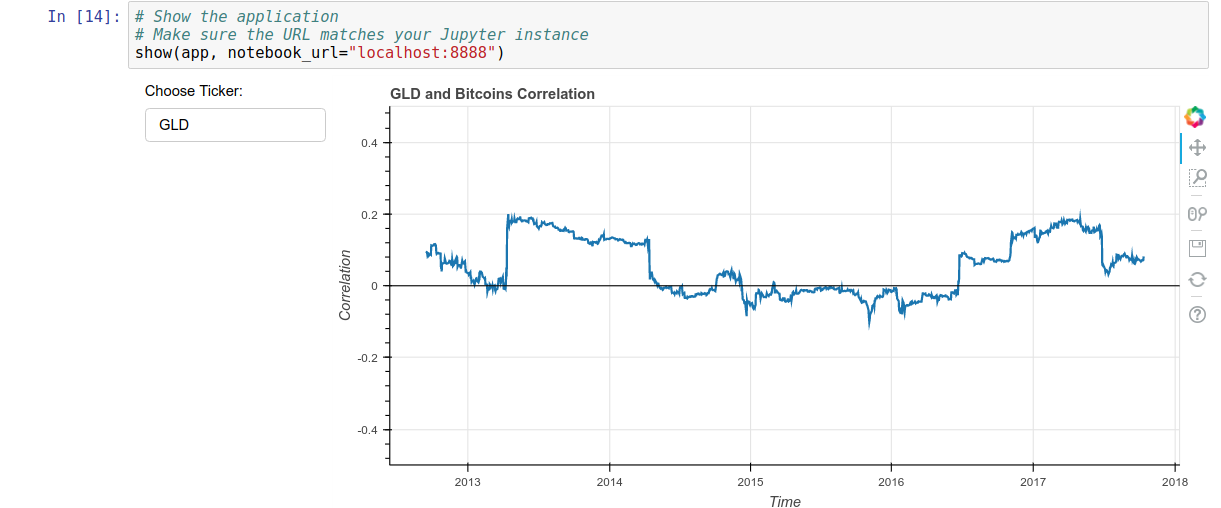

In [14]:
PATH = '/home/justin/Desktop/FALL_2017/'

# Gold using the ETF GLD
Image(filename = PATH + 'gold_plot.png')

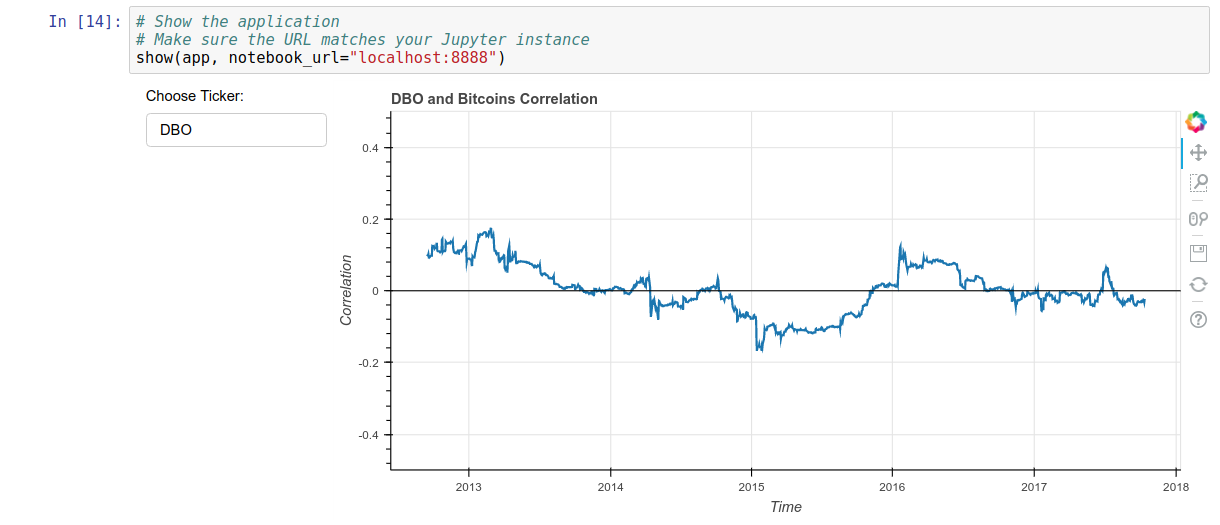

In [15]:
# Oil using ETF DBO 
Image(filename = PATH + 'oil_plot.png')

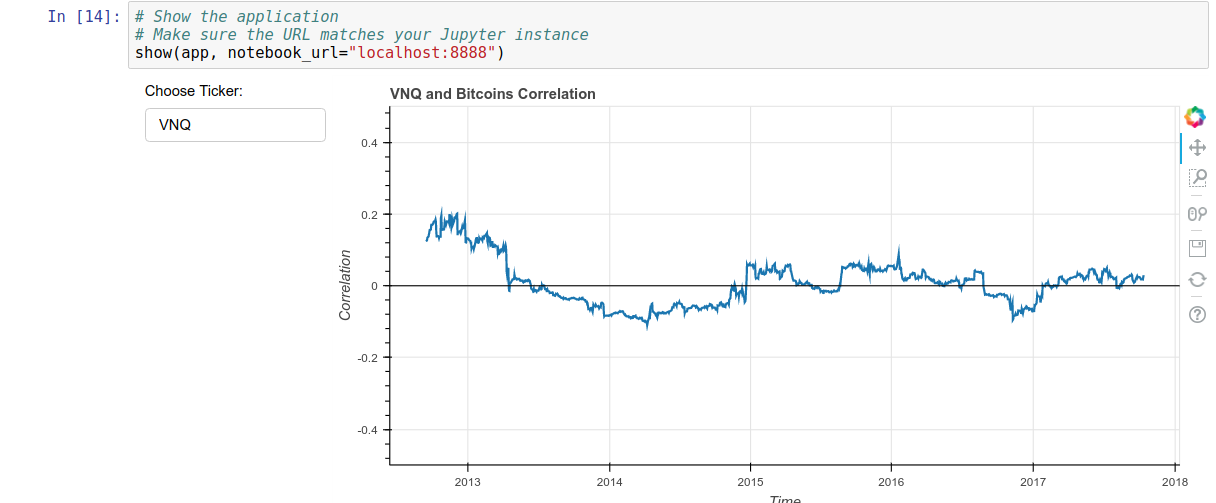

In [16]:
# Real Estate using ETF VNQ
Image(filename = PATH + 'real_estate_plot.png')

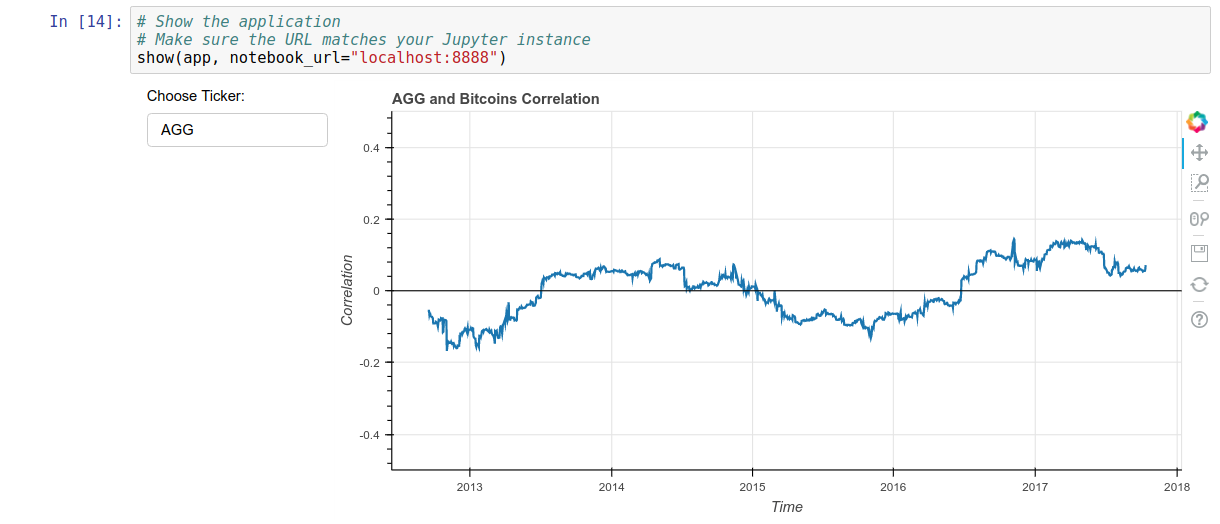

In [17]:
# Fixed Income using ETF AGG
Image(filename = PATH + 'fixed_income_plot.png')

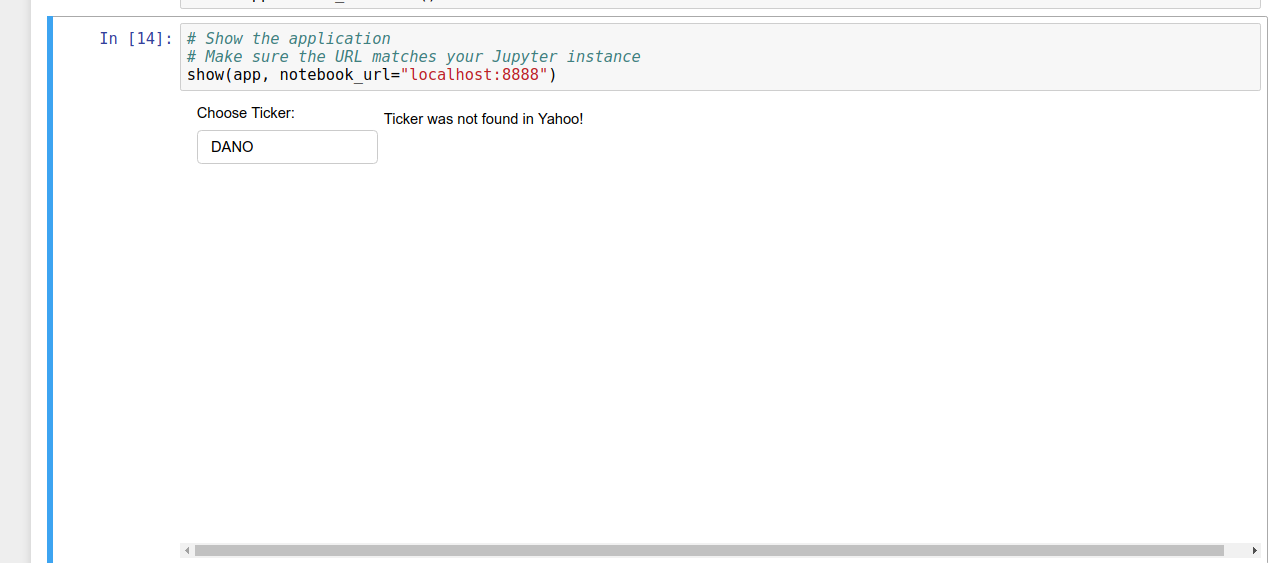

ERROR:bokeh.server.views.ws:Refusing websocket connection from Origin 'file://';                       use --allow-websocket-origin= to permit this; currently we allow origins {'localhost:8888'}


In [18]:
# An invalid ticker:
Image(filename = PATH + 'missing_ticker.png')

## Conclusion

Despite the issues of dynamically graphing the rolling correlation, the visualizations in part 1 and part 2 were sufficient in answering the research questions. By looking at the rolling correlation, it is clear that Bitcoin and  the major fiat currencies of the world have no correlation. Also, no trend of increased or decreased correlation is present. If nothing else, the research shows that adding some sort of exposure to cryptocurrencies may not only be profitable, but also provide a portfolio manager a great way to hedge against most other financial assets. 




References: <br>
    (1) https://seekingalpha.com/article/4047264-bitcoins-correlation-financial-assets<br>
    (2) https://github.com/ecerami/pydata-essentials/blob/master/bokeh/bokeh_notebook_embed.ipynb
